In [1]:
# %pip install ipynb
# %pip install face_recognition -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# import notebook
from ipynb.fs.full.facial_similarity_checker import *
from ipynb.fs.full.image_landmark_extractor import *

# import the necessary packages
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [3]:
# helper function 
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

In [6]:
def align_images(image, template, maxFeatures=500, keepPercent=0.2,
    debug=False):
    # convert both the input image and template to grayscale
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    extracter = LandmarkExtractor("shape_predictor_68_face_landmarks.dat")
    # image = cv2.imread("img/me_without_mask4.jpg")
    # image2 = cv2.imread("img/me_without_mask3.jpg")
    matches = extracter.get_landmarks(image, template, show=False)

    print(f"matches: {matches}")
    ptsA = np.zeros((len(matches[0]), 2), dtype="float")
    ptsB = np.zeros((len(matches[1]), 2), dtype="float")


    ptsA = np.array(matches[0])
    ptsB = np.array(matches[1])

    # print(f"ptsA: {ptsA}")
    # print(f"ptsB: {ptsB}")

    # compute the homography matrix between the two sets of matched
    # points
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=5.0)
    # print(f"H: {H}")
    
    # use the homography matrix to align the images
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(image, H, (w, h))
    
    # return the aligned image
    return aligned

x: 524	y: 810	Size: (467,467)
x: 325	y: 513	Size: (860,860)
{'verified': False, 'distance': 0.7485458799920035, 'threshold': 0.68, 'model': 'VGG-Face', 'detector_backend': 'opencv', 'similarity_metric': 'cosine', 'facial_areas': {'img1': {'x': 524, 'y': 810, 'w': 467, 'h': 467, 'left_eye': None, 'right_eye': None}, 'img2': {'x': 325, 'y': 513, 'w': 860, 'h': 860, 'left_eye': (890, 845), 'right_eye': (758, 1184)}}, 'time': 0.88}
The similarity between the images is:  0.7485458799920035
The images are the same person:  False


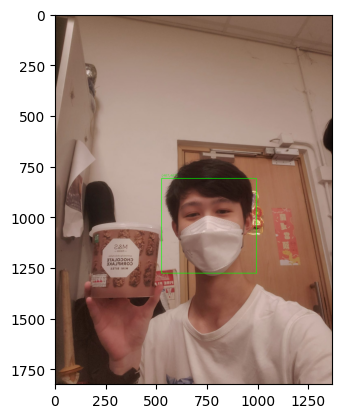

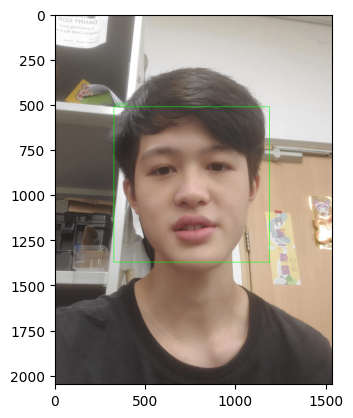

[INFO] loading images...
[INFO] aligning images...
len(faces): 2
 [rectangles[], rectangles[[(48, 110) (603, 665)]]]
rectangles[]
No face detected
rect: [(0, 0) (700, 700)] is_empty: False
landmarks: <_dlib_pybind11.full_object_detection object at 0x000001ABC6D529B0>
landmark img_0: [[116, 307], [120, 373], [132, 439], [149, 508], [182, 571], [223, 622], [267, 664], [323, 689], [390, 690], [454, 671], [512, 635], [557, 585], [594, 527], [618, 460], [620, 389], [614, 322], [606, 253], [141, 230], [163, 194], [205, 174], [253, 173], [299, 185], [368, 173], [413, 149], [465, 140], [513, 151], [547, 181], [337, 252], [340, 298], [343, 343], [347, 392], [289, 426], [321, 437], [354, 443], [387, 430], [421, 417], [193, 277], [219, 266], [249, 261], [280, 268], [252, 279], [221, 282], [409, 254], [436, 240], [466, 238], [494, 244], [468, 256], [439, 260], [269, 520], [299, 503], [332, 494], [360, 498], [388, 488], [429, 488], [470, 496], [434, 516], [396, 532], [366, 539], [338, 540], [304, 5

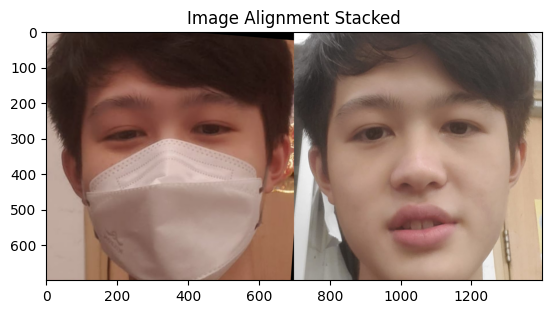

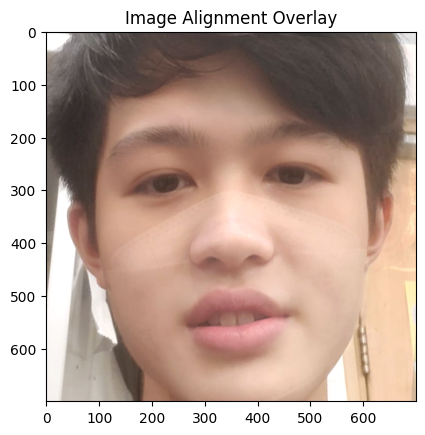

In [8]:
# construct the argument parser and parse the arguments
image_path = "img/me_with_mask.jpg"
template_path = "img/me_without_mask4.jpg"

checker = facial_similarity_checker()
checker.load_image(image_path, template_path)
checker.show_result(True)

area1, area2 = checker.get_facial_area()

# load the input image and template from disk
print("[INFO] loading images...")
image = cv2.imread(image_path)
template = cv2.imread(template_path)

image = image[area1.y:area1.y+area1.height, area1.x:area1.x+area1.width]
template = template[area2.y:area2.y+area2.height, area2.x:area2.x+area2.width]

# resize both the aligned and template images so we can easily
# visualize them on our screen
image = imutils.resize(image, width=700, height=700)
template = imutils.resize(template, width=700, height=700)

# align the images
print("[INFO] aligning images...")
aligned = align_images(image, template, debug=True)

# our first output visualization of the image alignment will be a
# side-by-side comparison of the output aligned image and the
# template
stacked = np.hstack([aligned, template])

# our second image alignment visualization will be *overlaying* the
# aligned image on the template, that way we can obtain an idea of
# how good our image alignment is
overlay = template.copy()
output = aligned.copy()
cv2.addWeighted(overlay, 1.0, output, 0.2, 0, output)

# show the two output image alignment visualizations
plt_imshow("Image Alignment Stacked", stacked)
plt.show()

plt_imshow("Image Alignment Overlay", output)
plt.show()